# Springboard Capstone 2: Tweet Sentiment Extraction

## Solution Approach 1: Simple Bag-of-Words with post processing output

Based on teh EDA on the dataset, we see that
1. If the sentiment is neutral, majority of the tweets have the entre text replicated in the selcted text
2. If the length of tweet is small(2-3 words), even then majority of words are selected
3. Selected text is usually 5-10 words for positive and negative sentiments

Based on this observations, we would like to test a bag-of-words approach to preductors with post processing to capture the phrase with higest correlation with the sentiment

In [1]:
# imports
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import re
import nltk

In [2]:
# Read data into memory
training_fn = r'../data/raw/train.csv'
test_fn = r'../data/raw/test.csv'

In [3]:
train_df = pd.read_csv(training_fn, index_col = 'textID')
test_df = pd.read_csv(test_fn, index_col = 'textID')

In [4]:
def drop_missing_rows(df_in):
    df_out = df_in.dropna(axis = 0)
    return df_out  

In [5]:
def text_preprocess(text):
    # Strip leading and lagging whitespace
    text = text.strip()
    
    # Remove accented characters
#     text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Convert all text to lower case
    text.lower()
    
    # Take raw text and remove all audience reactions
#     text = re.sub('\((.*?)\)', '', text)

    # Remove url's from the tweets.
#     text = re.sub(r'(https?://\S+)', '', text)
    return text

In [6]:
# Drop missing data
train_df = drop_missing_rows(train_df)

Need to add a prepocessing step where selected text is NaN for input text of NaN

In [7]:
train_df['clean_text'] = train_df.text.apply(text_preprocess)

In [8]:
train_df.head(5)

,text,selected_text,sentiment,clean_text
textID,,,,
cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"I`d have responded, if I were going"
549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Sooo SAD I will miss you here in San Diego!!!
088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me...
9642c003ef,what interview! leave me alone,leave me alone,negative,what interview! leave me alone
358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,"Sons of ****, why couldn`t they put them on th..."


## Train Model for Sentiment Analysis

The goal of our model is to get the words in each model which are predictive of a particular sentiment and find the phrase around the word as selected text. In the first part, we develop  amodel that can provide the words strongly predictive of a sentiment

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
# vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()

vectorizer.fit(train_df.clean_text)
X_train_full = vectorizer.transform(train_df.clean_text)
le = LabelEncoder()

y_train_full = le.fit_transform(train_df.sentiment)

In [60]:
X_train_full

<27480x26439 sparse matrix of type '<class 'numpy.float64'>'
	with 314805 stored elements in Compressed Sparse Row format>

In [10]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [11]:
X_train_full.shape

(27480, 26439)

In [12]:
# Get training and testing split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size = 0.3)

Lets train a Classification Model

In [13]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import roc_auc_score
bal_acc_scorer = make_scorer(balanced_accuracy_score, adjusted = True)
# ROC AUC score using One-vs-Rest and weighted by prevalence
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba = True, multi_class = 'ovr',average = "weighted")

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV


# nb = MultinomialNB()
clf = LogisticRegression(class_weight = 'balanced', multi_class = 'ovr', solver = 'newton-cg')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
y_prob = clf.predict_proba(X_train)

print ('Balanced accuracy score (training)is ', balanced_accuracy_score(clf.predict(X_train), y_train))
print ('ROC AUC score (training)is ', roc_auc_score(y_train, y_prob, average = "weighted", multi_class = 'ovr'))

Balanced accuracy score (training)is  0.8137125378949855
ROC AUC score (training)is  0.9282615225370816


In [16]:
# On Test set
y_pred_test = clf.predict(X_test)
y_prob_test = clf.predict_proba(X_test)

print ('Balanced accuracy score (test)is ', balanced_accuracy_score(clf.predict(X_test), y_test))
print ('ROC AUC score (test)is ', roc_auc_score(y_test, y_prob_test, average = "weighted", multi_class = 'ovr'))

Balanced accuracy score (test)is  0.6937214047069867
ROC AUC score (test)is  0.8355964431175137


In [17]:
C_ls = list(np.logspace(-5, 5, num=10))
# C_ls = [1.0]

In [18]:
# Grid Search CV
from sklearn.model_selection import GridSearchCV
C_ls = np.logspace(-5, 5, num=10)
param_grid = {'C':C_ls}
clf_grid = GridSearchCV(clf, param_grid=param_grid, scoring = roc_auc_scorer, n_jobs = -1)
clf_grid.fit(X_train, y_train)
clf_grid.cv_results_

{'mean_fit_time': array([ 0.2124506 ,  0.24681859,  0.33336821,  0.58366389,  0.98751073,
         1.58153391,  2.60389581,  5.00250034, 11.52904649, 20.65310993]),
 'std_fit_time': array([0.01593086, 0.01168824, 0.04578632, 0.03359315, 0.03871302,
        0.08584832, 0.16980322, 0.66154571, 1.64680038, 1.11436748]),
 'mean_score_time': array([0.01249728, 0.01249704, 0.00937338, 0.01562028, 0.01249466,
        0.00937257, 0.00625062, 0.01815143, 0.01528807, 0.00312343]),
 'std_score_time': array([0.01169049, 0.00624852, 0.00765333, 0.00988054, 0.00624733,
        0.00765267, 0.00765542, 0.00203477, 0.0006629 , 0.00624685]),
 'param_C': masked_array(data=[1e-05, 0.0001291549665014884, 0.0016681005372000592,
                    0.021544346900318846, 0.2782559402207126,
                    3.593813663804626, 46.41588833612782,
                    599.4842503189421, 7742.636826811277, 100000.0],
              mask=[False, False, False, False, False, False, False, False,
                   

We test the model performance using both the CountVectorizer and TfidfVectorizer. Then, we use Tfidf vectorizer as it gives higher performance

In [19]:
clf_best = clf_grid.best_estimator_

In [20]:
print ('The best parameter, C , selected is',clf_best.get_params()['C'])

The best parameter, C , selected is 3.593813663804626


In [21]:
best_roc_auc_score = roc_auc_score(y_test, clf_best.predict_proba(X_test), average = "weighted", multi_class = 'ovr')
print('Score of the best model score on the test set is', best_roc_auc_score)

Score of the best model score on the test set is 0.8353628722039163


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.66      0.67      2313
           1       0.65      0.68      0.67      3339
           2       0.76      0.73      0.74      2592

    accuracy                           0.69      8244
   macro avg       0.70      0.69      0.69      8244
weighted avg       0.69      0.69      0.69      8244



Confusion matrix, without normalization
[[1530  652  131]
 [ 576 2285  478]
 [ 134  570 1888]]
Normalized confusion matrix
[[0.6614786  0.281885   0.0566364 ]
 [0.17250674 0.68433663 0.14315663]
 [0.05169753 0.21990741 0.72839506]]


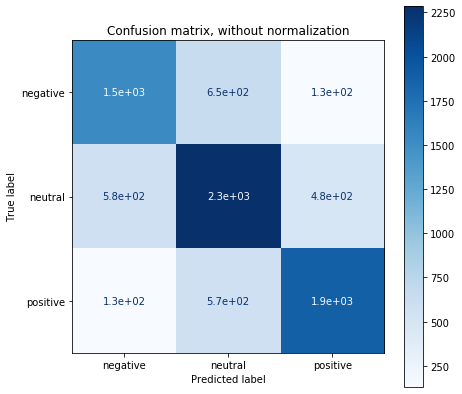

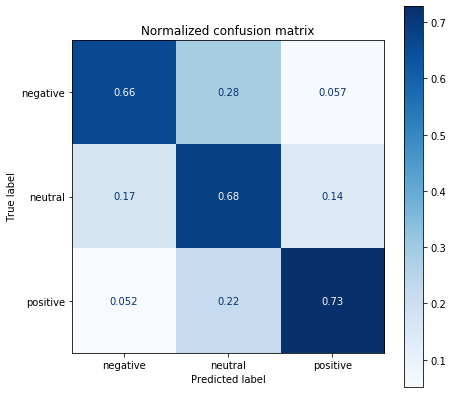

In [23]:
# Confusion Matrix of Classifier
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_best, X_test, y_test,
                                 display_labels=list(le.classes_),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    disp.figure_.set_size_inches((7,7))

    print(title)
    print(disp.confusion_matrix)

plt.show()

Use the trained model to get the probability of each calss for each word in the vectorizer

## Post Processing

In [24]:
words = np.array(vectorizer.get_feature_names())

In [25]:
words.shape

(26439,)

In [26]:
X_train_full.shape[1]

26439

In [27]:
x = np.eye(words.shape[0])

In [28]:
clf_predict_proba = clf_best.predict_proba(x)
# clf_predict_proba[:,1]

In [30]:
np.shape(clf_predict_proba)

(26439, 3)

In [31]:
le.transform(["positive"])[0]

2

In [32]:
print ('The encoded labels corresponding to classes \n',le.classes_, 'are \n',le.transform(le.classes_))

The encoded labels corresponding to classes 
 ['negative' 'neutral' 'positive'] are 
 [0 1 2]


In [33]:
probs_dict = {}
for sent in le.classes_:

    probs_dict[sent+'_probs'] = clf_predict_proba[:, le.transform([sent])[0]]
    ind = np.argsort(probs_dict[sent+'_probs'])
    # Get good and bad words
    good_words = words[ind[-5:]]
    bad_words = words[ind[:5]]
    # Get corresponding probabilities
    good_prob = probs_dict[sent+'_probs'][ind[-5:]]
    bad_prob = probs_dict[sent+'_probs'][ind[:5]]
    
    # Print Best and Worst predictive words
    print("Good words\t     P(%s | word)" %sent)
    for w, p in zip(good_words, good_prob):
        print("{:>20}".format(w), "{:.2f}".format(p))
    
    print("Bad words\t     P(%s | word)" %sent)
    for w, p in zip(bad_words, bad_prob):
        print("{:>20}".format(w), "{:.2f}".format(p))

Good words	     P(negative | word)
                hate 0.97
                fail 0.97
                miss 0.98
              stupid 0.98
               sucks 0.98
Bad words	     P(negative | word)
                love 0.00
                glad 0.00
              thanks 0.00
             awesome 0.00
                hope 0.00
Good words	     P(neutral | word)
            catching 0.87
             airport 0.87
                jump 0.87
             private 0.90
              invite 0.91
Bad words	     P(neutral | word)
               happy 0.00
                good 0.00
              thanks 0.00
                love 0.01
             awesome 0.01
Good words	     P(positive | word)
                good 0.99
             awesome 0.99
                love 0.99
               happy 1.00
              thanks 1.00
Bad words	     P(positive | word)
                 sad 0.00
                miss 0.00
               sorry 0.00
                hate 0.00
               sucks 0.00


Next for each tweet, we will try to look at the word with highest probability in a particular sentiment

### Select sub-tweets

We want to predict the probabilities of each word in tweet for a particular sentiment

In [127]:
le.transform(['neutral'])[0]

1

In [124]:
neg_proba = clf_predict_proba[:, le.transform(['negative'])[0]]
pos_proba = clf_predict_proba[:, le.transform(['positive'])[0]]
neu_proba = clf_predict_proba[:, le.transform(['neutral'])[0]]


In [176]:
tweet_tokenizer = vectorizer.build_tokenizer()
def select_predictive_word(text, sent):
    tweet_tokens = tweet_tokenizer(text)
    token_index = [vectorizer.vocabulary_[token.lower()] for token in tweet_tokens]
    tweet_probs = [clf_predict_proba[ix, le.transform([sent])[0]] for ix in token_index]
#     print(tweet_tokens)
#     print(tweet_probs)
    try:
        selected_text = tweet_tokens[np.argmax(tweet_probs)]
    except:
        selected_text = text
        
    return(selected_text)
    
vec_selected_text = np.vectorize(select_predictive_word)

In [182]:
def jaccard(str1, str2): 
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    jaccard_score = float(len(c)) / (len(a) + len(b) - len(c))
    return jaccard_score
vec_jaccard = np.vectorize(jaccard)

In [165]:
train_df.head(3)

,text,selected_text,sentiment,clean_text
textID,,,,
cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"I`d have responded, if I were going"
549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Sooo SAD I will miss you here in San Diego!!!
088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me...


In [197]:
predicted_selection1 = vec_selected_text(train_df.clean_text, train_df.sentiment)

In [198]:
predicted_selection1

array(['going', 'miss', 'my', ..., 'good', 'worth', 'going'],
      dtype='<U110')

Model Evaluations

In [199]:
print ('Trivial jaccard score(selected text and main text) is %.3f'\
           %vec_jaccard(train_df.clean_text, train_df.selected_text).mean())

Trivial jaccard score(selected text and main text) is 0.589


When prediction is taken to be most predictive word of the sentiment in the tweet, the jaccard score actually drops to 0.24 

In [200]:
print ('Jaccard score with predicted selection(selected text and predicted text) is %.3f'\
           %vec_jaccard(train_df.selected_text, predicted_selection1).mean())

Jaccard score with predicted selection(selected text and predicted text) is 0.240


Change the select predictive word to include the following conditions
1. For all tweets with neutral ratings, select entire tweet irrespective of actual tweet

In [202]:
def select_predictive_text2(text, sent):
    tweet_tokens = tweet_tokenizer(text)
    token_index = [vectorizer.vocabulary_[token.lower()] for token in tweet_tokens]
    tweet_probs = [clf_predict_proba[ix, le.transform([sent])[0]] for ix in token_index]
#     print(tweet_tokens)
#     print(tweet_probs)
    if sent == 'neutral':
        selected_text = text
    else:
        try:
            selected_text = tweet_tokens[np.argmax(tweet_probs)]
        except:
            selected_text = text
        
    return(selected_text)
    
vec_selected_text2 = np.vectorize(select_predictive_text2)

In [203]:
predicted_selection2 = vec_selected_text2(train_df.clean_text, train_df.sentiment)

In [204]:
print ('Jaccard score with predicted selection(selected text and predicted text, ver2) is %.3f'\
           %vec_jaccard(train_df.selected_text, predicted_selection2).mean())

Jaccard score with predicted selection(selected text and predicted text, ver2) is 0.593


To this, we add an additional rule as follows
2. For all tweets with less than 4 words, select entire text irrespective of sentiment

In [393]:
def select_predictive_text3(text, sent):
    tweet_tokens = tweet_tokenizer(text)
    token_index = [vectorizer.vocabulary_[token.lower()] for token in tweet_tokens]
    tweet_probs = [clf_predict_proba[ix, le.transform([sent])[0]] for ix in token_index]
#     print(tweet_tokens)
#     print(tweet_probs)
    if sent == 'neutral':
        selected_text = text
#         text_nourl = re.sub(r'(https?://\S+)', '', text)
#         selected_text = text_nourl
    elif len(tweet_tokens) < 6:
        selected_text = text
    else:
        try:
            selected_text = tweet_tokens[np.argmax(tweet_probs)]
        except:
            selected_text = text
        
    return(selected_text)
    
vec_selected_text3 = np.vectorize(select_predictive_text3)

In [394]:
predicted_selection3 = vec_selected_text3(train_df.clean_text, train_df.sentiment)

In [395]:
print ('Jaccard score with predicted selection(selected text and predicted text, ver3) is %.3f'\
           %vec_jaccard(train_df.selected_text, predicted_selection3).mean())

Jaccard score with predicted selection(selected text and predicted text, ver3) is 0.605


In [396]:
train_df['predicted_selection'] = predicted_selection3

In [397]:
train_df['predicted_jaccard'] = vec_jaccard(train_df.selected_text, train_df.predicted_selection)

In [398]:
train_df.head()

,text,selected_text,sentiment,clean_text,predicted_selection,predicted_jaccard,predicted_selection_parse,jaccard_parse
textID,,,,,,,,
cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"I`d have responded, if I were going","I`d have responded, if I were going",1.000000,"I`d have responded, if I were going",1.000000
549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Sooo SAD I will miss you here in San Diego!!!,miss,0.000000,Sooo SAD I will miss you here in San Diego!!!,0.200000
088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me...,my boss is bullying me...,0.166667,my boss is bullying me...,0.166667
9642c003ef,what interview! leave me alone,leave me alone,negative,what interview! leave me alone,what interview! leave me alone,0.600000,what interview! leave me alone,0.600000
358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,"Sons of ****, why couldn`t they put them on th...",couldn,0.000000,"Sons of ****, why couldn`t they put them on t...",0.214286


Lets write this to a file and investigae common sources of mismatch

In [400]:
train_df.to_csv('../data/interim/bag_of_word_predictions_v3.csv')

## Use Parse Trees

In the next version, we will make use of parse trees to get phrases around the words best predictive of sentiment in the tweet

In [245]:
import spacy
from spacy import displacy
import en_core_web_sm

In [247]:
# import en_core_web_lg
nlp = en_core_web_sm.load()

In [442]:
sents = list(doc.sents)

In [443]:
sents

[both electronic keys stopped working.,
 there is no keyhole!,
 cant get in my car.,
 so much for technology]

In [444]:
chunks = list(doc.noun_chunks)
chunks

[both electronic keys, no keyhole, my car, technology]

In [447]:
str(chunks[0])

'both electronic keys'

In [464]:
def select_predictive_text4(text, sent):
    tweet_tokens = tweet_tokenizer(text)
    token_index = [vectorizer.vocabulary_[token.lower()] for token in tweet_tokens]
    tweet_probs = [clf_predict_proba[ix, le.transform([sent])[0]] for ix in token_index]
#     tweet_splits = text.
#     print(tweet_tokens)
#     print(tweet_probs)
    if sent == 'neutral':
#         text_nourl = re.sub(r'(https?://\S+)', '', text)
        selected_text = text
    elif len(tweet_tokens) < 6:
        selected_text = text
    else:
        try:
            selected_word = tweet_tokens[np.argmax(tweet_probs)]
            doc = nlp(text)
            chunks = list(doc.noun_chunks)
            sents = list(doc.sents)
            for n_chunk in chunks:
                if selected_word in str(n_chunk):
                    selected_text = str(n_chunk)
#                     print (selected_text)
                    break
            if selected_text == '':
                selected_text = selected_word
        except:
            selected_text = text
        
    return(selected_text)
    
vec_selected_text4 = np.vectorize(select_predictive_text4)

In [465]:
predicted_selection4 = vec_selected_text4(train_df.text, train_df.sentiment)

In [466]:
print ('Jaccard score with predicted selection(selected text and predicted text, ver4) is %.3f'\
           %vec_jaccard(train_df.selected_text, predicted_selection4).mean())

Jaccard score with predicted selection(selected text and predicted text, ver4) is 0.584


In [467]:
train_df['predicted_selection_parse'] = predicted_selection4
train_df['jaccard_parse'] = vec_jaccard(train_df.selected_text, train_df.predicted_selection_parse)

In [468]:
train_df.to_csv('../data/interim/bag_of_word_predictions_parsed_v4.csv')

In [489]:
def select_predictive_text5(text, sent):
    tweet_tokens = tweet_tokenizer(text)
    token_index = [vectorizer.vocabulary_[token.lower()] for token in tweet_tokens]
    tweet_probs = [clf_predict_proba[ix, le.transform([sent])[0]] for ix in token_index]
#     tweet_splits = text.
#     print(tweet_tokens)
#     print(tweet_probs)
    if sent == 'neutral':
#         text_nourl = re.sub(r'(https?://\S+)', '', text)
        selected_text = text
    elif len(tweet_tokens) < 5:
        selected_text = text
    else:
        try:
            selected_word = tweet_tokens[np.argmax(tweet_probs)]
            doc = nlp(text)
            for token in doc:
                if selected_word in str(token.text):
                    selected_text = doc[token.i-2:token.i+3]
#                     print(selected_text)
            if selected_text == '':
                selected_text = selected_word
        except:
            selected_text = text
        
    return(selected_text)
    
vec_selected_text5 = np.vectorize(select_predictive_text5)

In [490]:
predicted_selection5 = vec_selected_text5(train_df.text, train_df.sentiment)

In [491]:
print ('Jaccard score with predicted selection(selected text and predicted text, ver5) is %.3f'\
           %vec_jaccard(train_df.selected_text, predicted_selection5).mean())

Jaccard score with predicted selection(selected text and predicted text, ver5) is 0.589


## Conclusion

Of all the approaches tested, best performance on training set is obtained on version 3 with a mean jaccard score of 0.605. However, this is only a small improvement over the trivial jaccard score of 0.589

In [492]:
vec_selected_text_best = np.vectorize(select_predictive_text3)